# Doc2Vecによる可視化

In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

#元データ読み込み
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
#記号の前後にスペースを入れるtokenizeを設定
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s)

In [3]:
from tqdm import tqdm
for i in tqdm(range(len(train))):
    train.iloc[i,1]=tokenize(train.iloc[i,1])

100%|██████████████████████████████████████████████████████████████████████████| 159571/159571 [36:50<00:00, 72.19it/s]


In [4]:
#none列を作成
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D ' aww ! He matches this background colour I...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man , I ' m really not trying to edit war...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,""" \nMore\nI can ' t make any real suggestions...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You , sir , are my hero . Any chance you re...",0,0,0,0,0,0,1


In [7]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#Doc2vecのtrainデータを格納
trainDoc = []

y=0
for i in tqdm(train['comment_text']):
    #タグはindexとする
    tag = y
    #分かち書きをリスト化
    pl = i.split(' ')
    #タグをリスト化
    tl=[tag]
    
#     print(pl)
#     print(tag)
    tagDoc = TaggedDocument(words=pl, tags=tl) 
    trainDoc.append(tagDoc)
    y=y+1

model = Doc2Vec(documents=trainDoc, epochs=100, min_count=1)

100%|███████████████████████████████████████████████████████████████████████| 159571/159571 [00:03<00:00, 52920.62it/s]


In [8]:
#Doc2vecをデータ全体に適用
import numpy as np

doc2_list=[]
for i in range(len(train)):
    doc2_list.append(model.docvecs[i])

#結果をデータフレーム化(100次元のベクトルに変換される)
df_doc2vec=pd.DataFrame(np.array(doc2_list))
df_doc2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.119742,0.250699,2.442165,1.248451,-0.390692,0.071043,-0.782515,-1.547992,-0.715456,0.845580,...,-0.863704,-1.020432,-1.469643,1.377593,1.371461,0.436643,-0.045989,1.590320,-0.132774,-0.021805
1,-0.656749,1.091204,2.051423,-2.120332,-1.105484,0.074540,0.318394,-1.354739,-0.827836,0.859829,...,0.268094,-1.215516,-1.098437,0.758371,-0.262725,0.204340,-0.209171,-0.134222,1.167697,0.658725
2,-0.202877,0.818150,-0.152208,-0.563693,-0.831067,1.015470,-0.030970,-0.538429,0.250785,0.275472,...,1.095343,-1.024443,0.448396,0.703773,-0.015902,2.387356,-0.781511,0.448556,1.471485,-0.637705
3,0.338395,1.303369,2.481315,-1.666457,-0.789264,-3.286874,-1.956848,-0.925942,0.513392,2.167291,...,0.739728,-0.583449,1.214887,-1.890461,-0.136860,-1.112207,-0.782913,-0.929210,-0.500792,0.571230
4,-1.502111,-0.081782,0.844801,0.960948,-0.458985,0.191740,0.655598,-1.215142,-1.241667,0.203315,...,0.044776,-0.263713,-0.414829,-0.146787,-0.175978,-0.036023,-0.347785,-0.147758,-0.530962,-1.898655


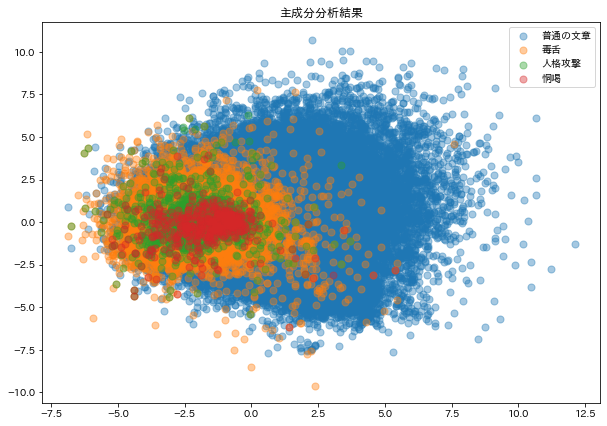

In [13]:
#PCA
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca_result=pca.fit_transform(df_doc2vec)

train['pca1']=pca_result[:,0]
train['pca2']=pca_result[:,1]

import japanize_matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))

#for i in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
for i in ['none','toxic','identity_hate','threat']:
    temp=train[train[i]==1]
    plt.scatter(temp['pca1'],temp['pca2'],alpha=0.4,s=50,label=i)
plt.title('主成分分析結果')
plt.legend(['普通の文章','毒舌','人格攻撃','恫喝'])